# Exploratory Data Analysis for Assesing Pathogenicity Problem  - Custom Parsing

This notebook was created  to showcase EDA for assesing pathogenicity problem. This notebook utilizes custom parsing implemented according to expert's specifications.

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import dalex as dx
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from utils.utils import get_dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
df = get_dataset("data/", samples=["EE_015", "EE_050", "EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [4]:
df.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred,ACMG_class
0,chr1,15820,G,T,.,0,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,Uncertain%40Significance
1,chr1,17385,G,A,.,0,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,Uncertain%40Significance
2,chr1,17697,G,C,.,0,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,Benign
3,chr1,133129,G,A,.,0,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,Uncertain%40Significance
4,chr1,183629,G,A,.,0,0,0,0,0,...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,Benign


In [5]:
df["ACMG_class"]

,ACMG_class,ACMG_class
0,Uncertain%40Significance,Uncertain%40Significance
1,Uncertain%40Significance,Uncertain%40Significance
2,Benign,Benign
3,Uncertain%40Significance,Uncertain%40Significance
4,Benign,Benign
...,...,...
444439,Uncertain%40Significance,Uncertain%40Significance
444440,Uncertain%40Significance,Uncertain%40Significance
444441,Uncertain%40Significance,Uncertain%40Significance
444442,Uncertain%40Significance,Uncertain%40Significance


The target attribute is ACMG_class. The cardinality of this attribute is 5 with the number of occurences of each example being written below. As can be seen some mutations are much rarer than others, so techniques to fight against problems related to minority class will need to be employed.

C:\Users\mateu\AppData\Local\Temp\ipykernel_672\1765661103.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ACMG_class', order=df['ACMG_class'].value_counts().index, palette='coolwarm')


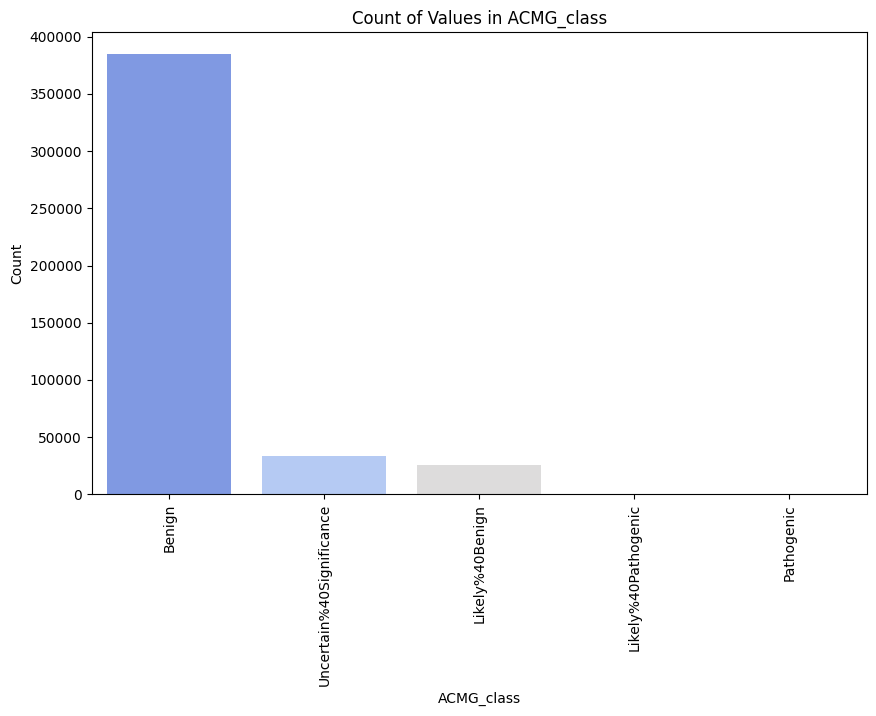

In [6]:
df = df.loc[:, ~df.columns.duplicated()]
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ACMG_class', order=df['ACMG_class'].value_counts().index, palette='coolwarm')
plt.xlabel('ACMG_class')
plt.ylabel('Count')
plt.title('Count of Values in ACMG_class')
plt.xticks(rotation=90)
plt.show()

## Nans Section

Exploring the Nans present in the dataset - visualizations and summary

Counting Nans

In [7]:
nan_count_per_column = df.isna().sum()
nan_count_per_column[nan_count_per_column>0]

AS_SB_TABLE               140174
ECNT                      140174
GERMQ                     140174
MBQ                       140174
MFRL                      140174
MPOS                      140174
POPAF                     140174
RPA                       140174
RU                        140174
STR                       140174
STRQ                      140174
TLOD                      140174
cosmicFathMMPrediction    140174
cosmicFathMMScore         140174
SYMBOL                     42674
Feature_type               12585
Feature                    12585
BIOTYPE                    12598
EXON                      302853
INTRON                    253015
HGVSc                     111466
Amino_acids               393016
Codons                    393014
Existing_variation         11545
DISTANCE                  347708
STRAND                     14683
SYMBOL_SOURCE              42674
CANONICAL                 159822
MANE_SELECT               244963
MANE_PLUS_CLINICAL        444035
gnomADe_AF

Below Visualization is meant to provide information about the number of NaNs in chosen columns. Basically, we choose every column that has more than 100 000 Nans, meaning around 1/4th. If such a high numbers of Nans is present, me may consider dropping the column or doing something else with it. As such, We ended up visualizing all attributes for each number of Nans is greater than 100 000 to decide what to do with these columns farther. Some columns are all Nans or close to all Nans, as such dropping this data may be necessary.

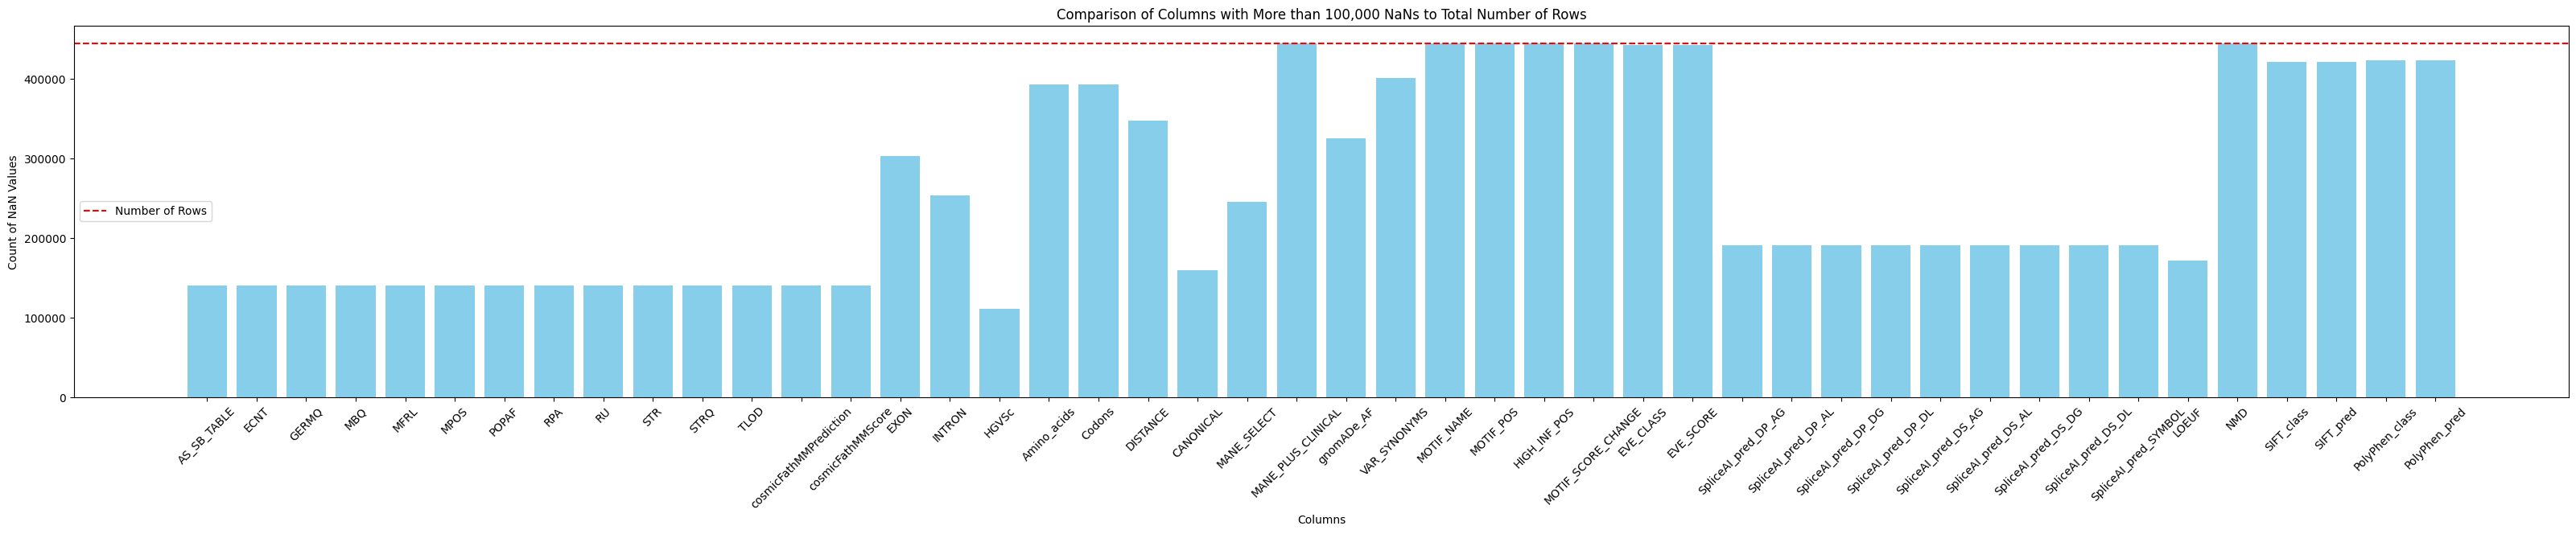

In [8]:
columns_with_nans = []
nan_counts = []
nan_threshold = 100000

for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > nan_threshold:
        columns_with_nans.append(column)
        nan_counts.append(nan_count)

total_rows = len(df)

plt.figure(figsize=(40, 6))
plt.bar(columns_with_nans, nan_counts, color='skyblue')
plt.axhline(y=total_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count of NaN Values')
plt.title('Comparison of Columns with More than 100,000 NaNs to Total Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Summary of Columns

In [9]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_count': df.isnull().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

pd.set_option('display.max_rows', 118)
nans_df = inspect_columns(df)
nans_df

,unique,cardinality,with_null,null_count,null_pct,1st_row,random_row,last_row,dtype
#CHROM,False,76,False,0,0.00,chr1,chr19,chrY,object
POS,False,275143,False,0,0.00,15820,39890175,56856670,int64
REF,False,3555,False,0,0.00,G,T,G,object
ALT,False,2881,False,0,0.00,T,G,T,object
QUAL,False,9986,False,0,0.00,.,.,467.77,object
FILTER_strand_bias,False,2,False,0,0.00,0,0,0,int64
FILTER_haplotype,False,2,False,0,0.00,0,0,0,int64
FILTER_fragment,False,2,False,0,0.00,0,0,0,int64
FILTER_clustered_events,False,2,False,0,0.00,0,0,0,int64
FILTER_germline,False,2,False,0,0.00,0,0,0,int64


Showing Only Nan Columns

In [10]:
nans_df = nans_df[nans_df['null_count'] > 0]
nans_df = nans_df.drop(columns = ["unique", "last_row", "1st_row", "with_null", "random_row"])

nans_df

,cardinality,null_count,null_pct,dtype
AS_SB_TABLE,86334,140174,31.54,object
ECNT,44,140174,31.54,float64
GERMQ,93,140174,31.54,float64
MBQ,26,140174,31.54,float64
MFRL,815,140174,31.54,float64
MPOS,51,140174,31.54,float64
POPAF,1,140174,31.54,float64
RPA,28,140174,31.54,float64
RU,1307,140174,31.54,object
STR,2,140174,31.54,float64


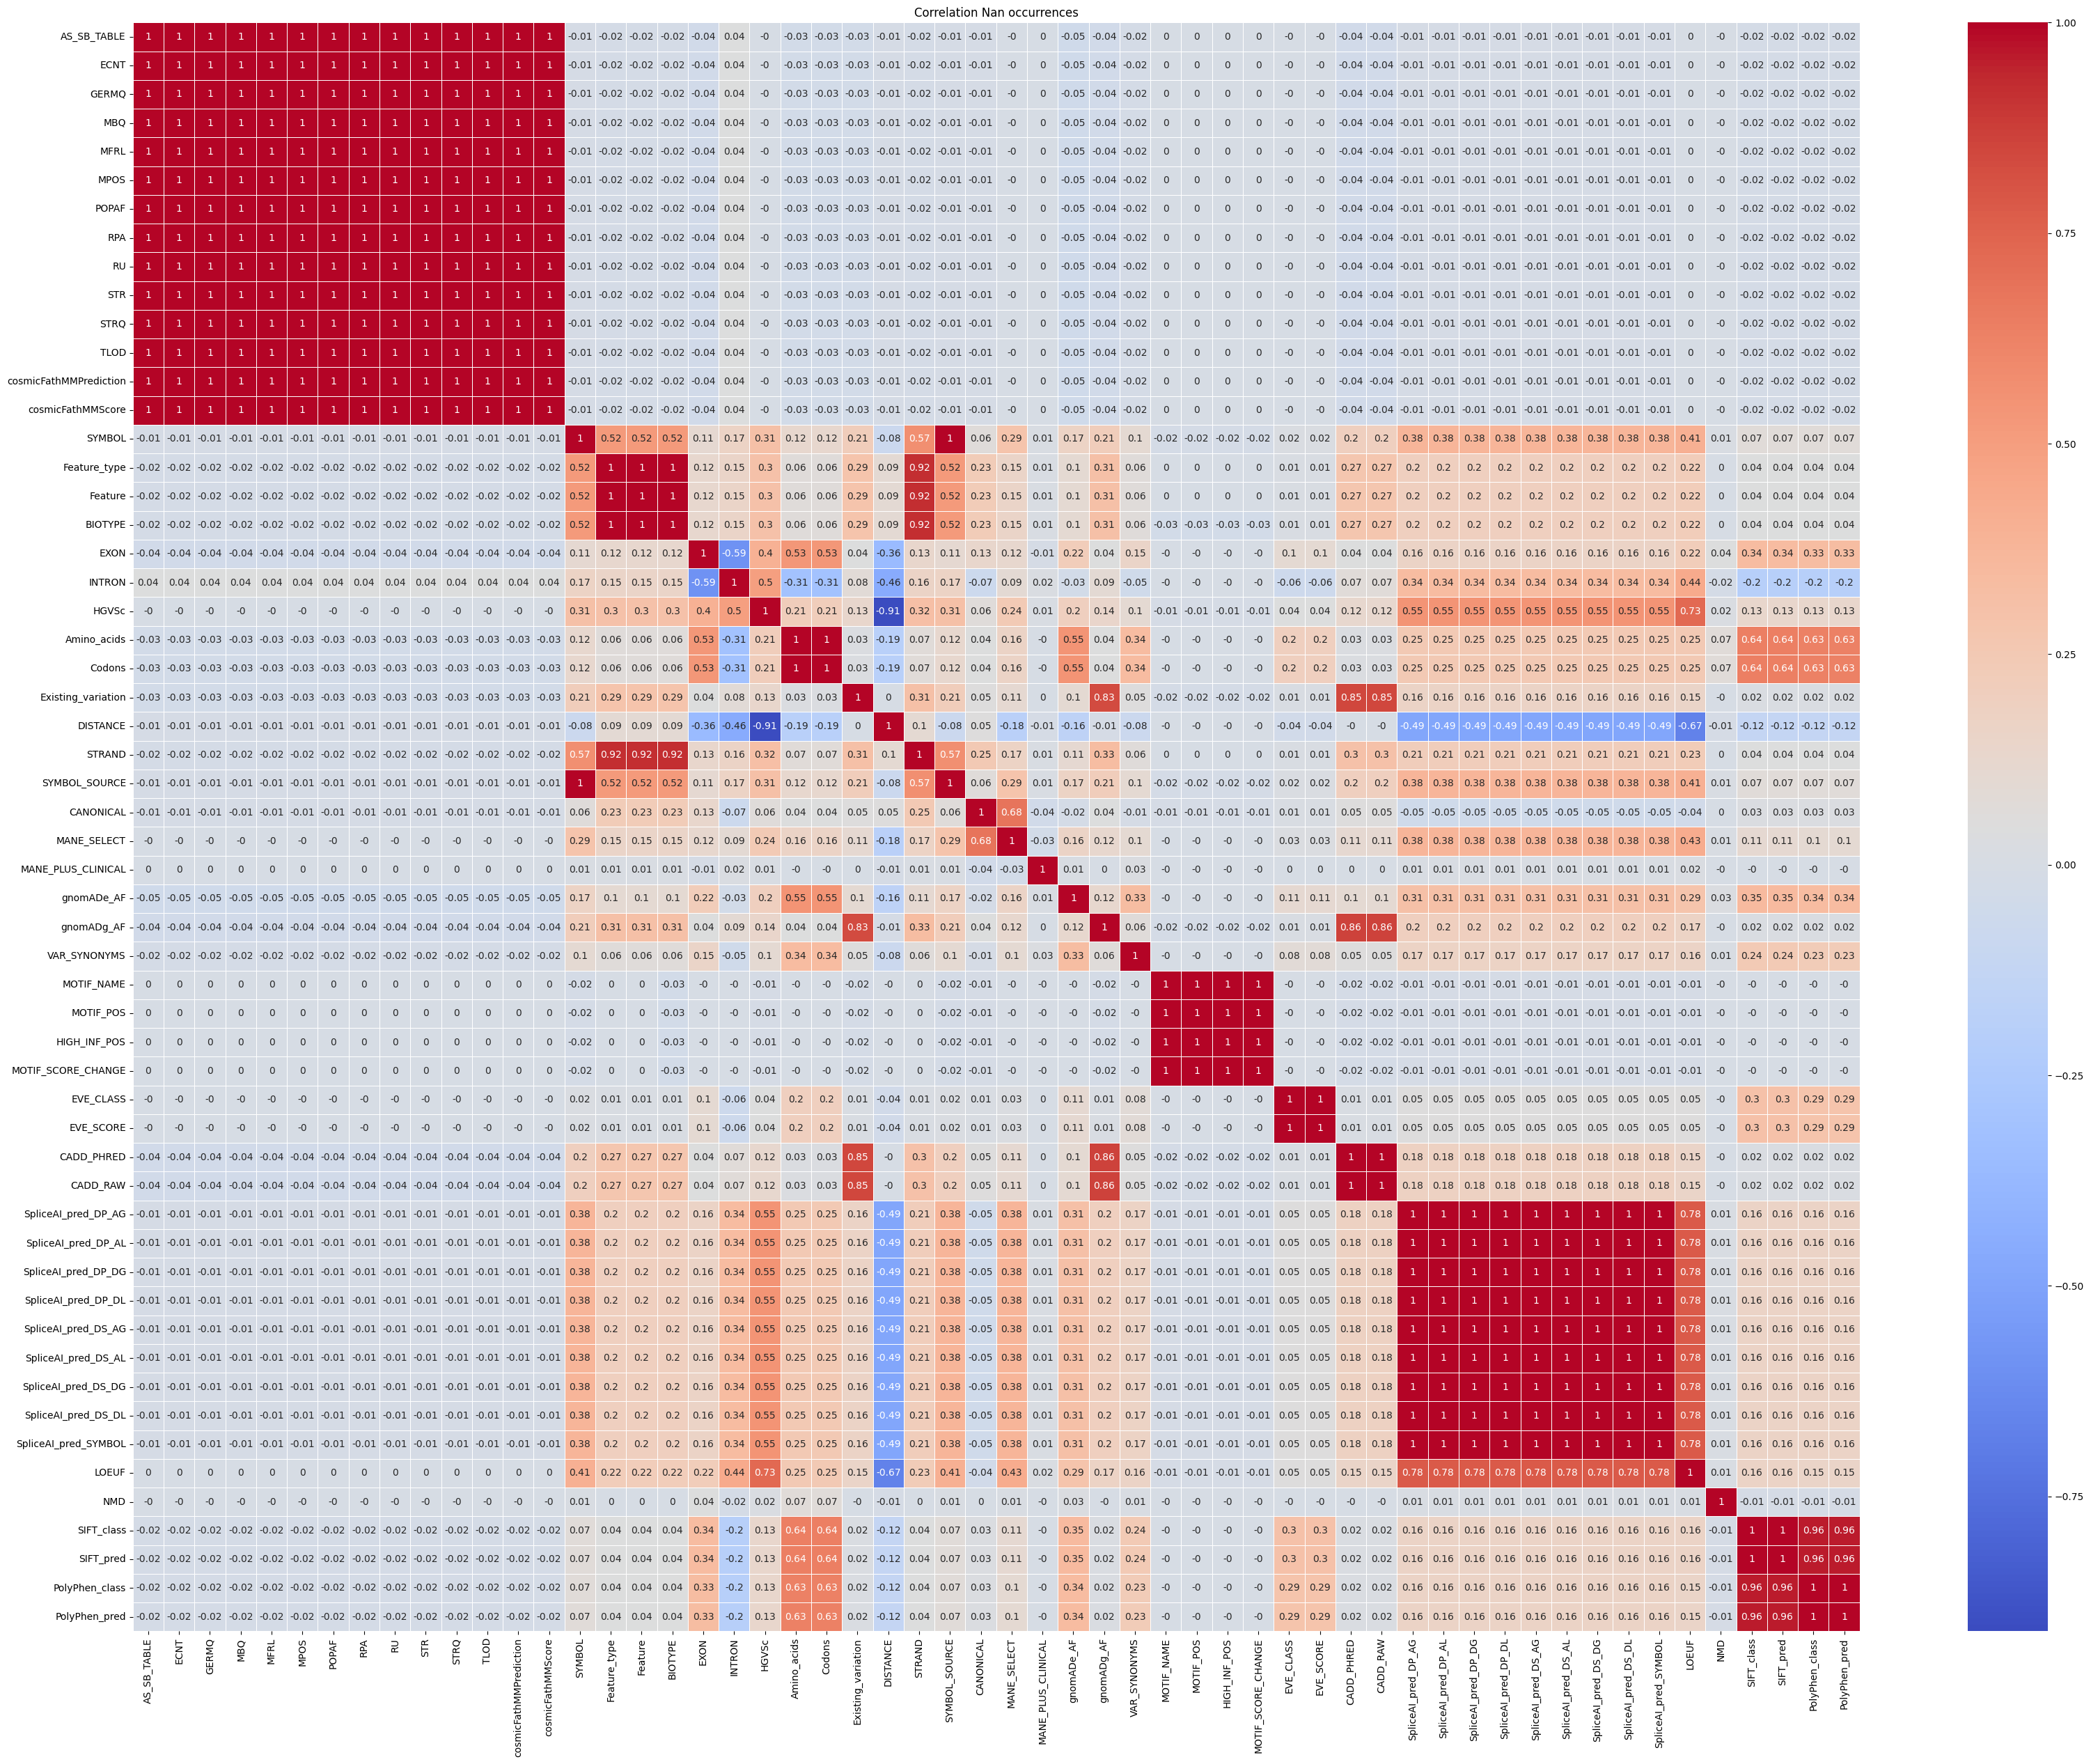

In [11]:
columns_with_nan = df.columns[df.isnull().any()]
df_with_nan = df[columns_with_nan]
nan_masks = df_with_nan.isnull()
nan_masks = nan_masks.astype(int)
nan_correlation = nan_masks.corr()
nan_correlation = nan_correlation.round(2)
plt.figure(figsize=(40, 30))
sns.heatmap(nan_correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Nan occurrences')
plt.show()

Correlation of Nans with ACMG_class 

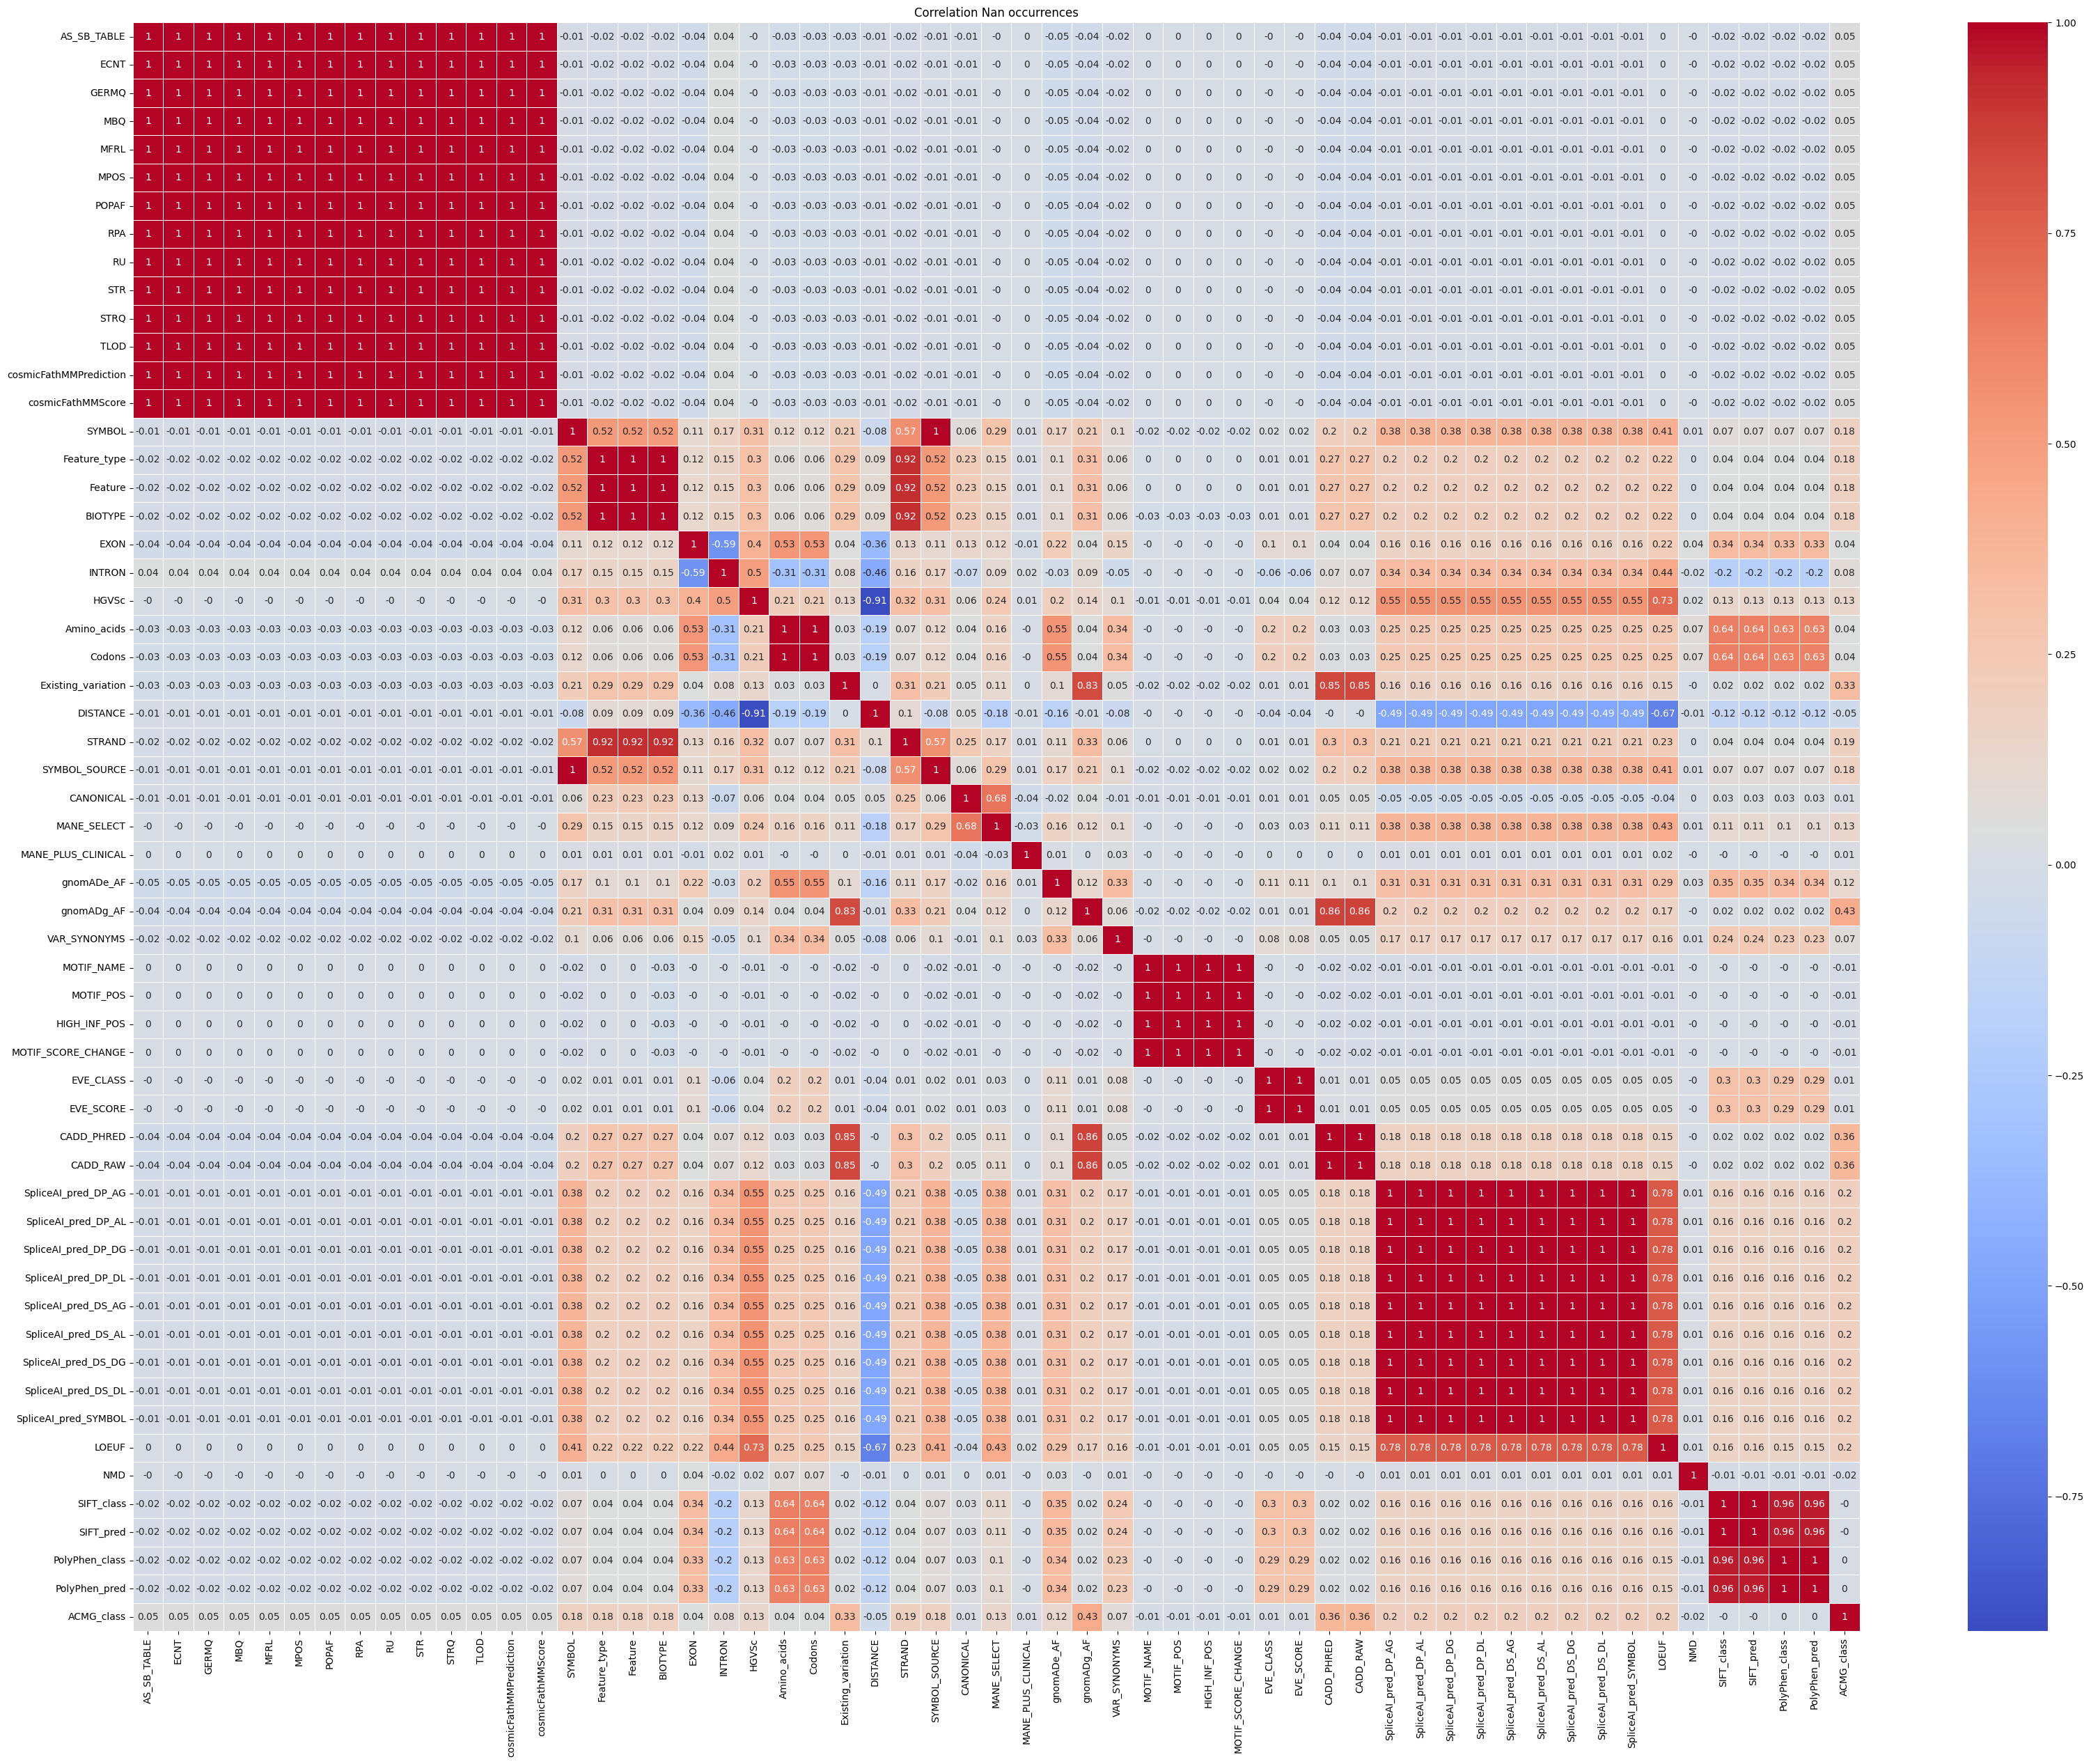

In [18]:
columns_with_nan = df.columns[df.isnull().any()]
columns_to_include = list(columns_with_nan) + ['ACMG_class']

df_with_nan = df[columns_to_include]
df_with_nan['ACMG_class'] = df_with_nan['ACMG_class'].astype('category').cat.codes
nan_masks = df_with_nan.isnull()
nan_masks = nan_masks.astype(int)
nan_masks['ACMG_class'] = df_with_nan['ACMG_class']
nan_correlation = nan_masks.corr()
nan_correlation = nan_correlation.round(2)
plt.figure(figsize=(40, 30))
sns.heatmap(nan_correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Nan occurrences')
plt.show()

Highest Correlations of Nans to ACMG_class

In [19]:
correlation_threshold = 0.15
correlated_columns = nan_correlation['ACMG_class'][abs(nan_correlation['ACMG_class']) > correlation_threshold].index
for column in correlated_columns:
    print(f"{column}: {nan_correlation['ACMG_class'][column]}")

SYMBOL: 0.18
Feature_type: 0.18
Feature: 0.18
BIOTYPE: 0.18
Existing_variation: 0.33
STRAND: 0.19
SYMBOL_SOURCE: 0.18
gnomADg_AF: 0.43
CADD_PHRED: 0.36
CADD_RAW: 0.36
SpliceAI_pred_DP_AG: 0.2
SpliceAI_pred_DP_AL: 0.2
SpliceAI_pred_DP_DG: 0.2
SpliceAI_pred_DP_DL: 0.2
SpliceAI_pred_DS_AG: 0.2
SpliceAI_pred_DS_AL: 0.2
SpliceAI_pred_DS_DG: 0.2
SpliceAI_pred_DS_DL: 0.2
SpliceAI_pred_SYMBOL: 0.2
LOEUF: 0.2
ACMG_class: 1.0


## Datatype Visualizations

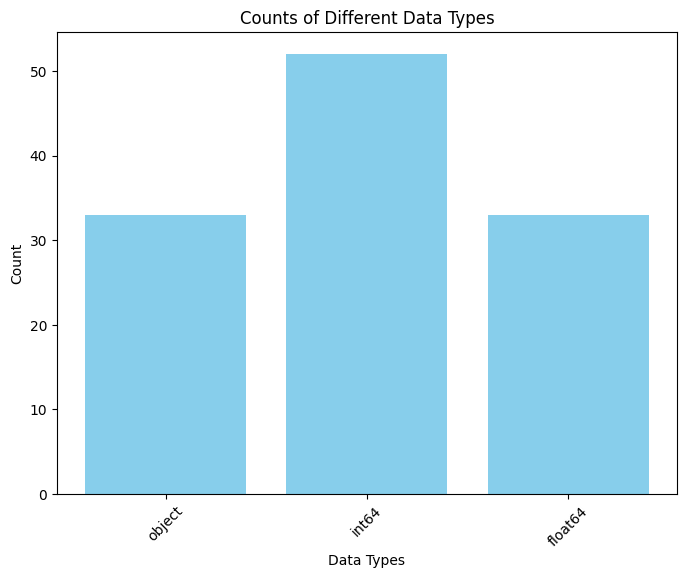

In [12]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types')
plt.xticks(rotation=45)
plt.show()

## Proposed Preprocessing

This section includes a function performing the preprocessing steps. This function should be copied and pasted into the utils section as well for the sake of simplicity and re-usibility in the model section.

In [20]:
def preprocess(df, one_hot_nans = True, fill_median = False):
    new_df = df.copy()
    if one_hot_nans:
        for column in new_df.columns:
            if new_df[column].isnull().any():
                new_df[column + '_is_nan'] = new_df[column].isnull().astype(int)
    for column in new_df.columns:
        if new_df[column].isnull().any():
            if new_df[column].dtype == 'object':
                new_df[column].fillna("No Value", inplace=True)
            else:
                if fill_median:
                    new_df[column].fillna(new_df[column].median(), inplace=True)
                else:
                    new_df[column].fillna(new_df[column].min() - 1, inplace=True)
    return new_df

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,chr1,15820,G,T,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,chr1,17385,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,chr1,17697,G,C,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,chr1,133129,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,chr1,183629,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


### Showing different proposed preprocessing schemes below:

In [21]:
preprocessed_df1 = preprocess(df)
preprocessed_df1.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,chr1,15820,G,T,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,chr1,17385,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,chr1,17697,G,C,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,chr1,133129,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,chr1,183629,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [22]:
preprocessed_df2 = preprocess(df, fill_median=True)
preprocessed_df2.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,chr1,15820,G,T,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,chr1,17385,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,chr1,17697,G,C,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,chr1,133129,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,chr1,183629,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [23]:
preprocessed_df3 = preprocess(df, one_hot_nans = False)
preprocessed_df3.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,chr1,15820,G,T,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
1,chr1,17385,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
2,chr1,17697,G,C,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
3,chr1,133129,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
4,chr1,183629,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0


## Encoding Objects to Categories

Used Functions and Example Use

In [47]:
def encode(df, target_column, target_mapping):
    new_df = df.copy()
    label_encoders = {}
    for column in new_df.columns:
        if new_df[column].dtype == 'object' and column!=target_column:
            label_encoders[column] = LabelEncoder()
            try:
                new_df[column] = label_encoders[column].fit_transform(new_df[column])
            except:
                new_df[column] = label_encoders[column].fit_transform(new_df[column].astype(str))
        elif new_df[column].dtype == 'object' and column==target_column:
            new_df[target_column] = new_df[target_column].map(target_mapping)
    return new_df, label_encoders, target_mapping

In [48]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"

In [50]:
temp_df,encoders,target_mapping = encode(preprocessed_df1, target_column, custom_mapping)
temp_df.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [51]:
def get_mapping(encoders, expected_column):
    for column, encoder in encoders.items():
        if column == expected_column:
            print(f"{column} mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")
            break

get_mapping(encoders, "cosmicFathMMPrediction")

cosmicFathMMPrediction mapping: {'0': 0, 'Benign': 1, 'Likely%40Benign': 2, 'Likely%40Pathogenic': 3, 'No Value': 4, 'Pathogenic': 5}


In [52]:
target_mapping

{'Benign': 0,
 'Likely%40Benign': 1,
 'Uncertain%40Significance': 2,
 'Likely%40Pathogenic': 3,
 'Pathogenic': 4}

Using on defined dataframes

In [53]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"

In [54]:
encoded_df1, encoders1, target_mapping1 = encode(preprocessed_df1, target_column, custom_mapping)
encoded_df1.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [55]:
encoded_df2, encoders2, target_mapping2 = encode(preprocessed_df2, target_column, custom_mapping)
encoded_df2.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [56]:
encoded_df3, encoders3, target_mapping3 = encode(preprocessed_df3, target_column, custom_mapping)
encoded_df3.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_strand_bias,FILTER_haplotype,FILTER_fragment,FILTER_clustered_events,FILTER_germline,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,0,15820,1773,2117,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
1,0,17385,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
2,0,17697,1773,721,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
3,0,133129,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
4,0,183629,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0


## Data type counts

In [58]:
def plot_dtypes(df):
    dtype_counts={}
    for val in df.dtypes:
        try:
            dtype_counts[str(val)]+=1
        except:
            dtype_counts[str(val)]=1

    data_types = list(dtype_counts.keys())
    counts = list(dtype_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(data_types, counts, color='skyblue')
    plt.xlabel('Data Types')
    plt.ylabel('Count')
    plt.title('Counts of Different Data Types')
    plt.xticks(rotation=45)
    plt.show()

Dataframe 1

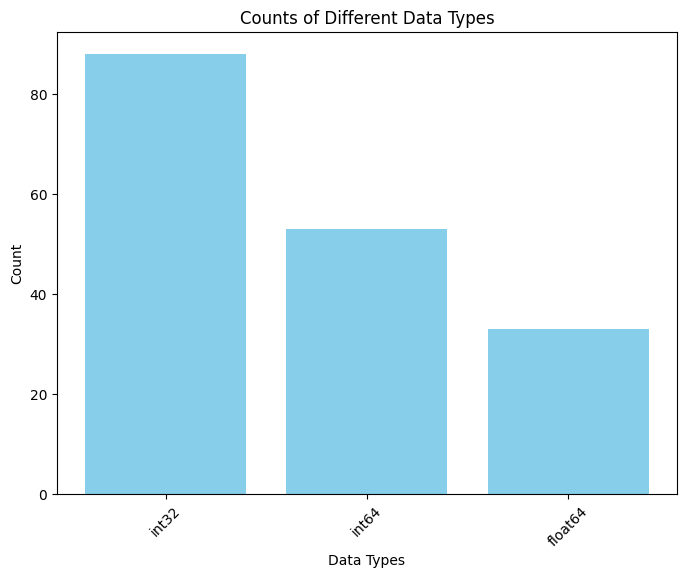

In [59]:
plot_dtypes(encoded_df1)

Dataframe 2

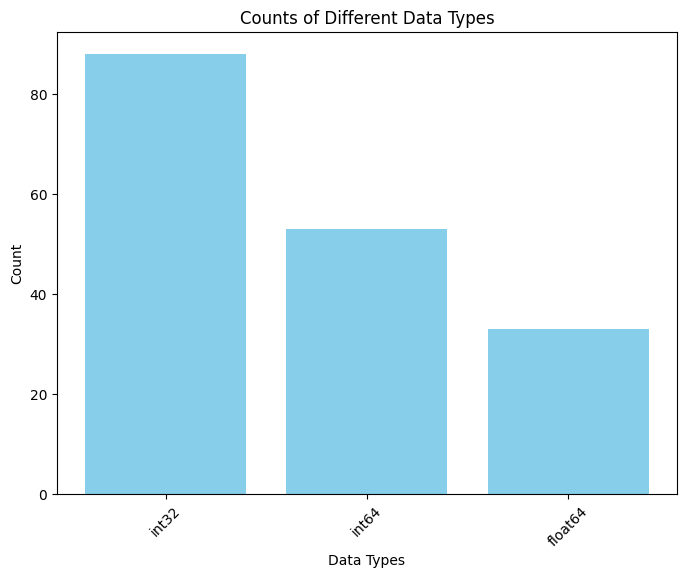

In [60]:
plot_dtypes(encoded_df2)

Dataframe 3

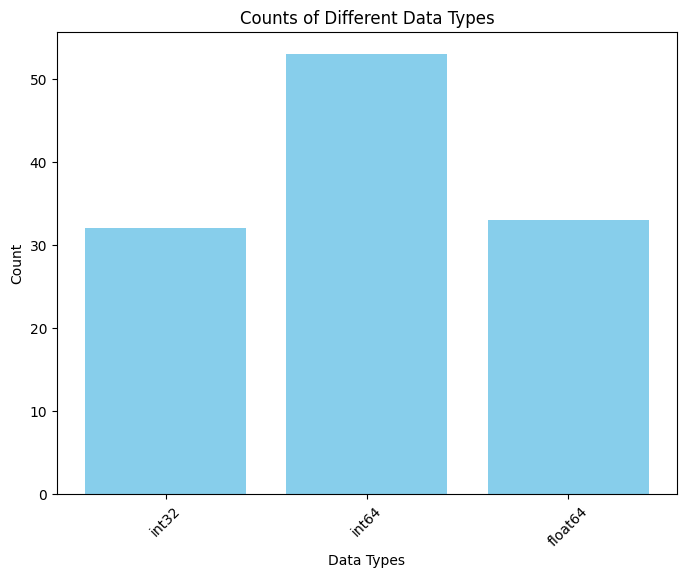

In [61]:
plot_dtypes(encoded_df3)

## Heatmaps of Correlations

In [66]:
def get_corr_heatmap(df):
    numeric_df = df.select_dtypes(include=['int64', 'float64', 'int32'])

    correlation_matrix = numeric_df.corr()
    average_correlation = correlation_matrix.abs().mean(axis=1)
    average_correlation = average_correlation.round(2)
    top_features = average_correlation.nlargest(20).index

    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap for Top 20 Features with Highest Average Correlation')
    plt.show()

Dataframe 1

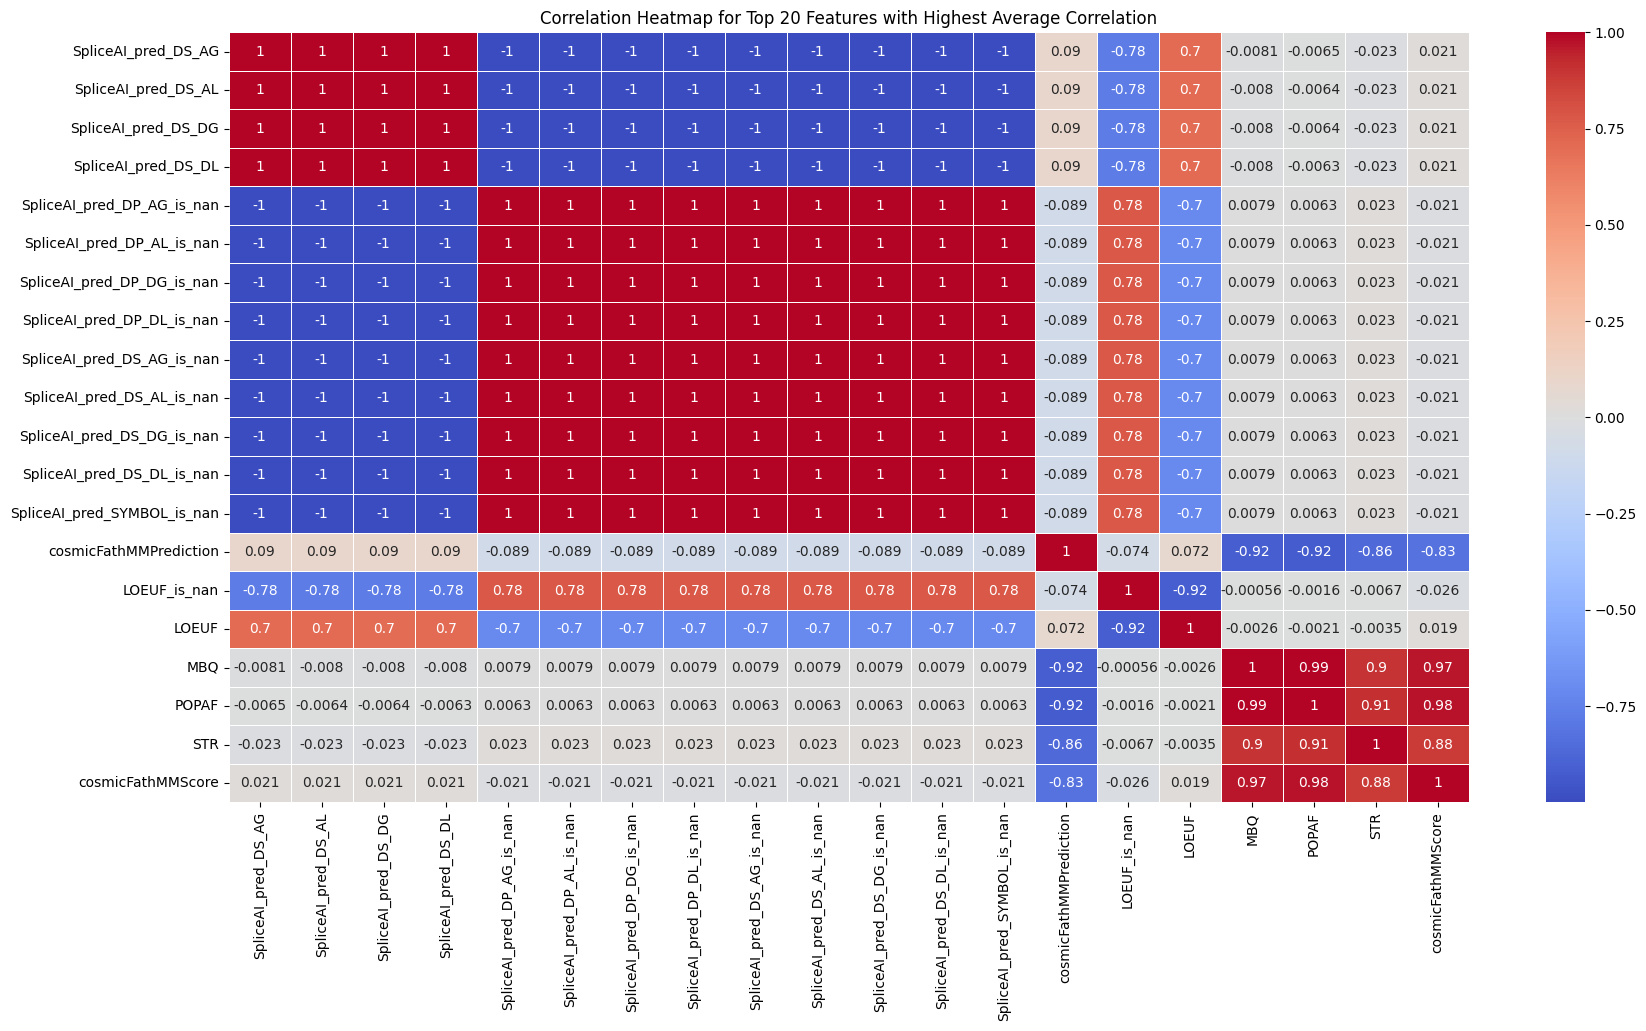

In [67]:
get_corr_heatmap(encoded_df1)

Datframe 2

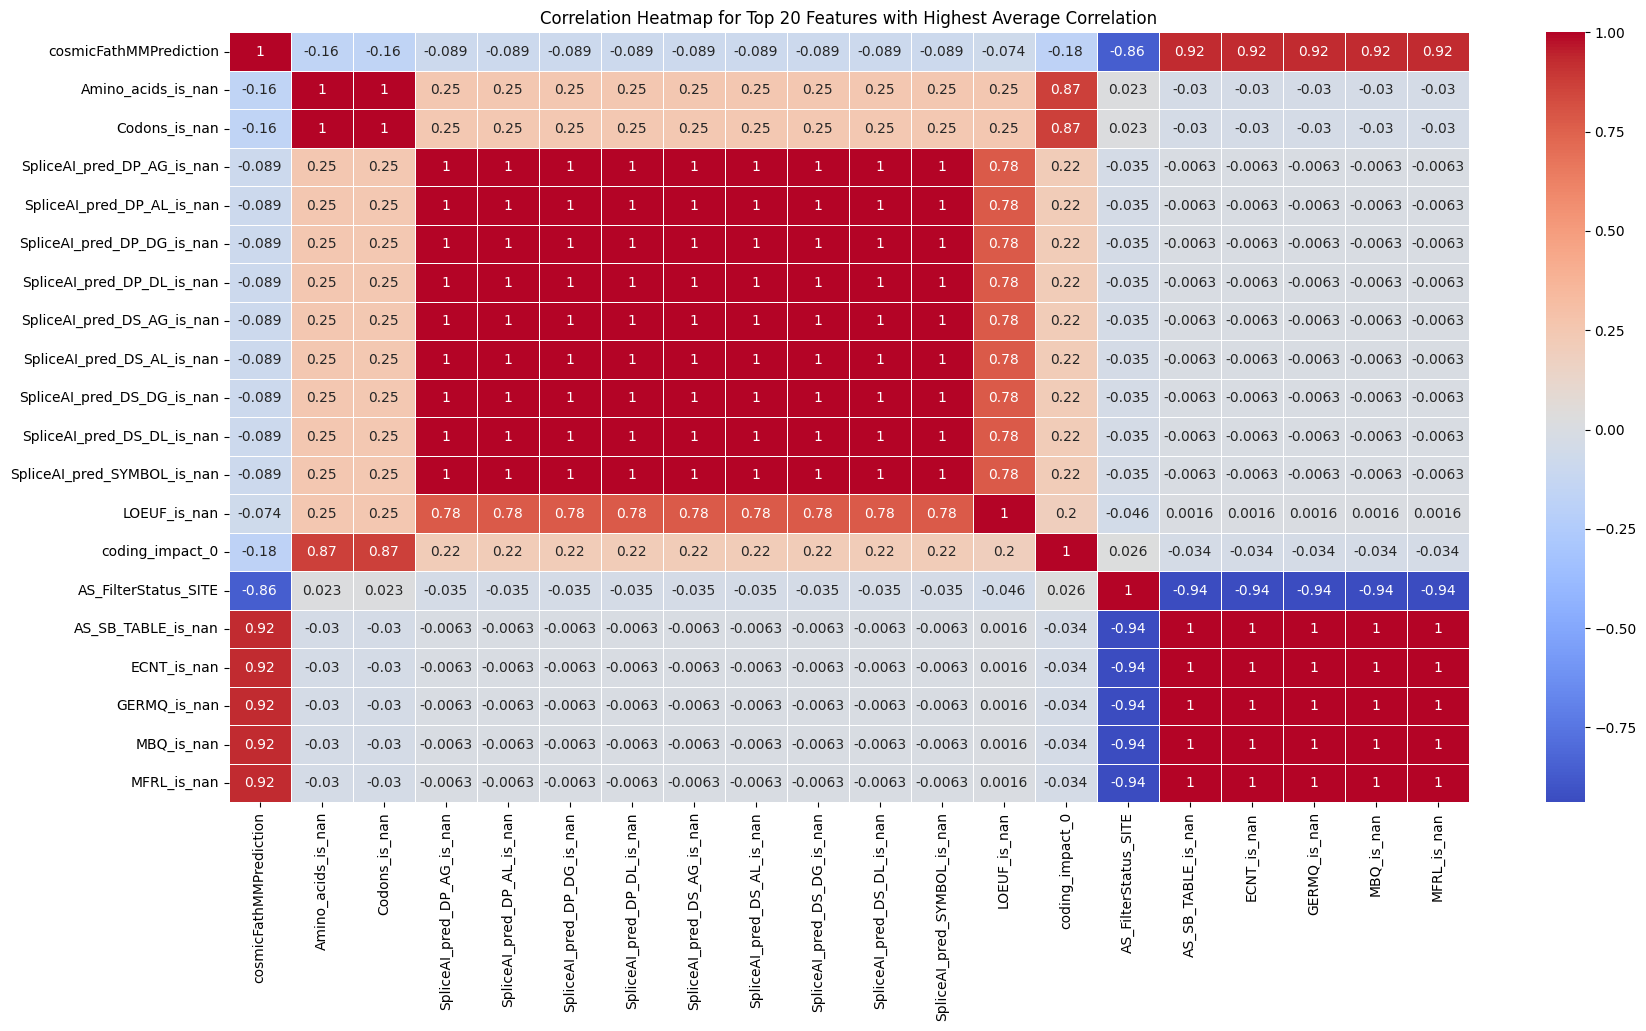

In [68]:
get_corr_heatmap(encoded_df2)

Dataframe 3

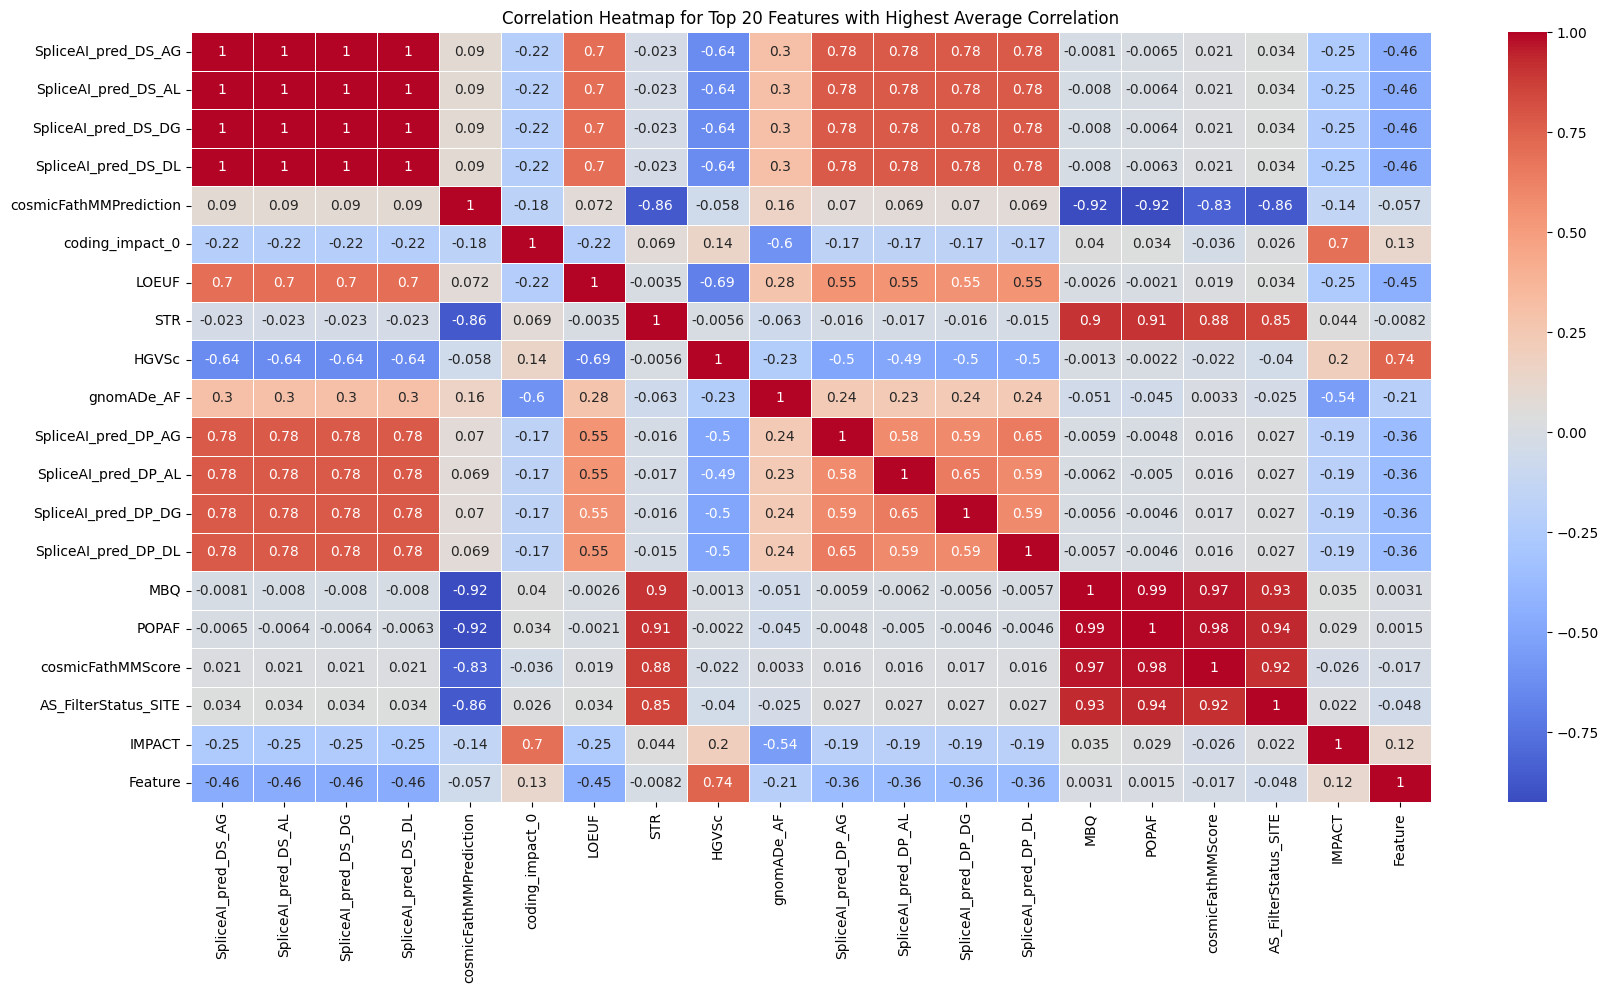

In [69]:
get_corr_heatmap(encoded_df3)

## Correlation and Mutual Information for ACMG_class

### Correlation

In [70]:
def get_corr_target(df, target_column):
    correlation_with_ACMG_class = df.corr()[target_column].drop(target_column)

    top_columns = correlation_with_ACMG_class.abs().nlargest(20).index

    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')
    plt.xlabel(f'Correlation with {target_column}')
    plt.ylabel('Column Name')
    plt.title(f'Correlation of Top 20 Columns with {target_column}')
    plt.show()

Dataframe 1

C:\Users\mateu\AppData\Local\Temp\ipykernel_672\2461259536.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')


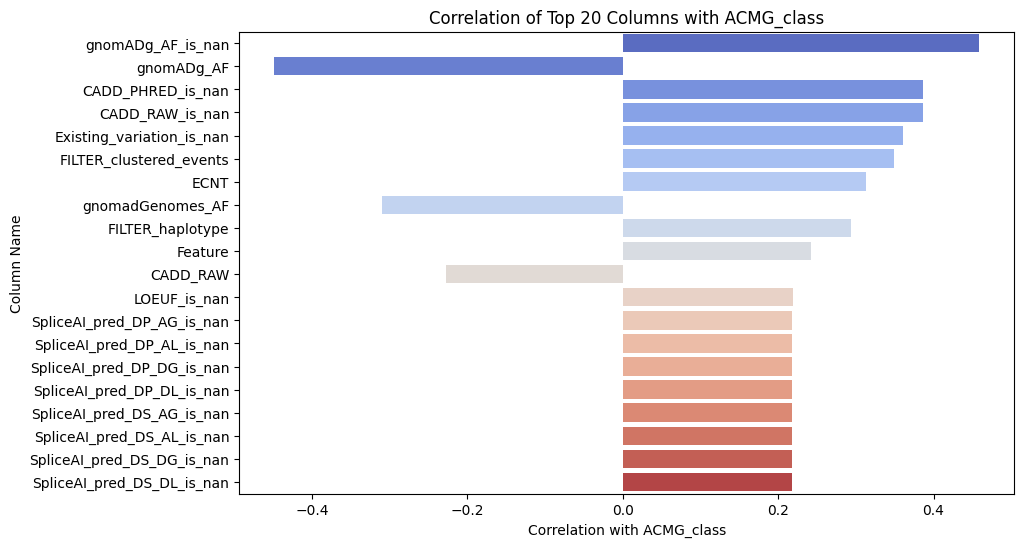

In [71]:
target_col = "ACMG_class"
get_corr_target(encoded_df1, target_col)

Dataframe 2

C:\Users\mateu\AppData\Local\Temp\ipykernel_672\2461259536.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')


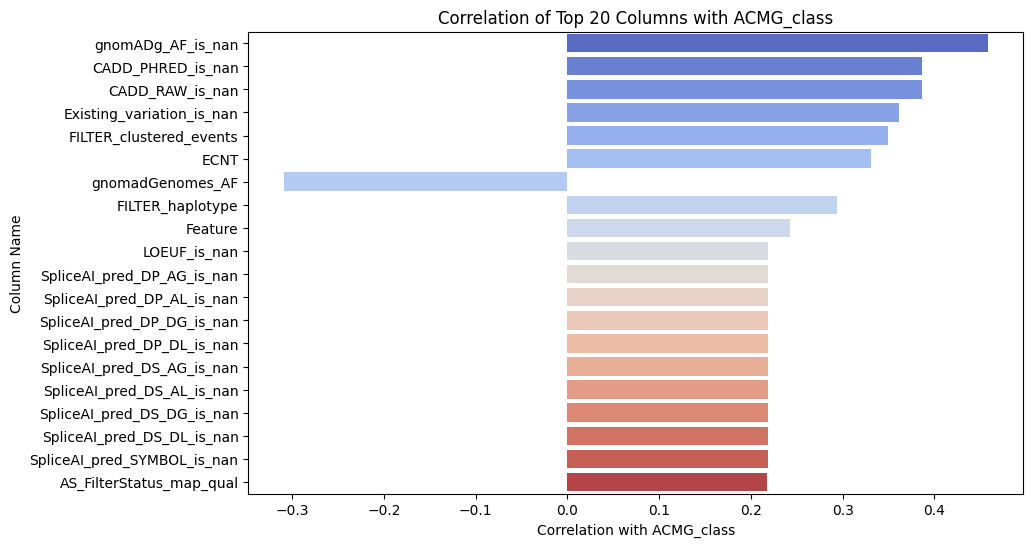

In [72]:
get_corr_target(encoded_df2, target_col)

Dataframe 3

C:\Users\mateu\AppData\Local\Temp\ipykernel_672\2461259536.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')


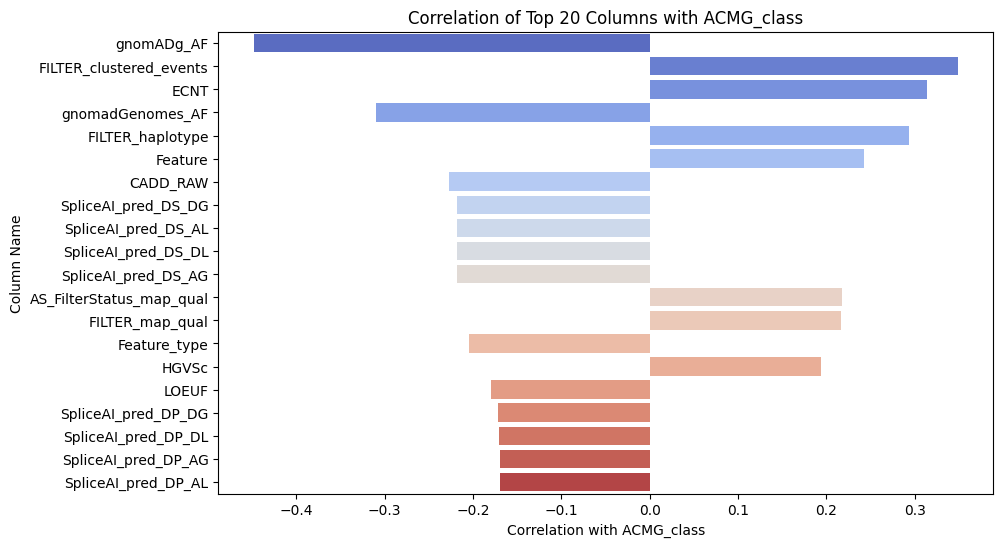

In [73]:
get_corr_target(encoded_df3, target_col)

### Mutual Information

In [74]:
def get_mutual_info_plot(df, target_column):
    df_copy = df.copy()
    X = df_copy.drop(columns=[target_column])
    y = df_copy[target_column]
    mutual_info = mutual_info_classif(X, y)


    mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
    mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
    top_features = mutual_info_df.head(20)

    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Mutual Information'], color='skyblue')
    plt.xlabel('Mutual Information')
    plt.ylabel('Feature')
    plt.title(f'Mutual Information with {target_column} for Top 20 Features')
    plt.show()

Dataframe 1

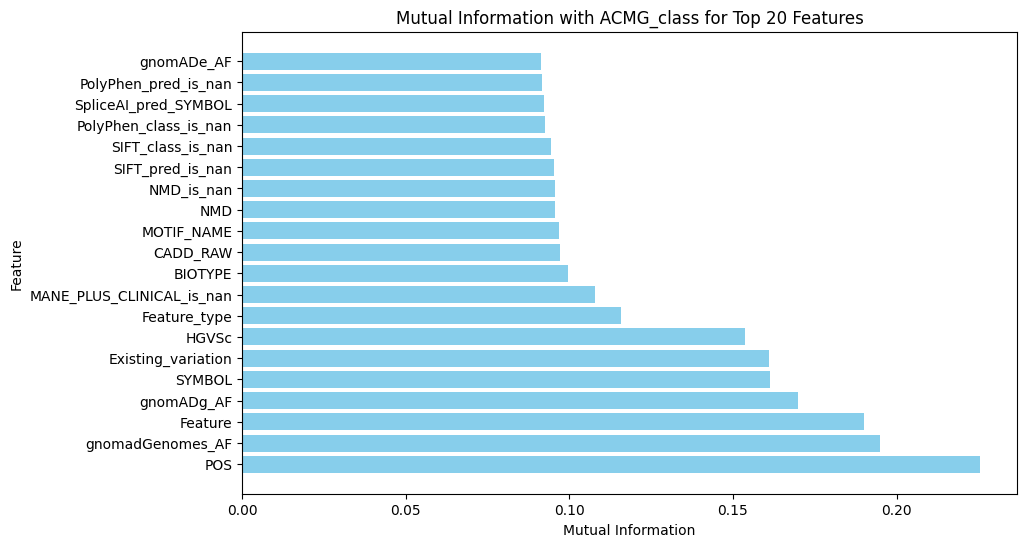

In [75]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df1, target_col)

Datframe 2

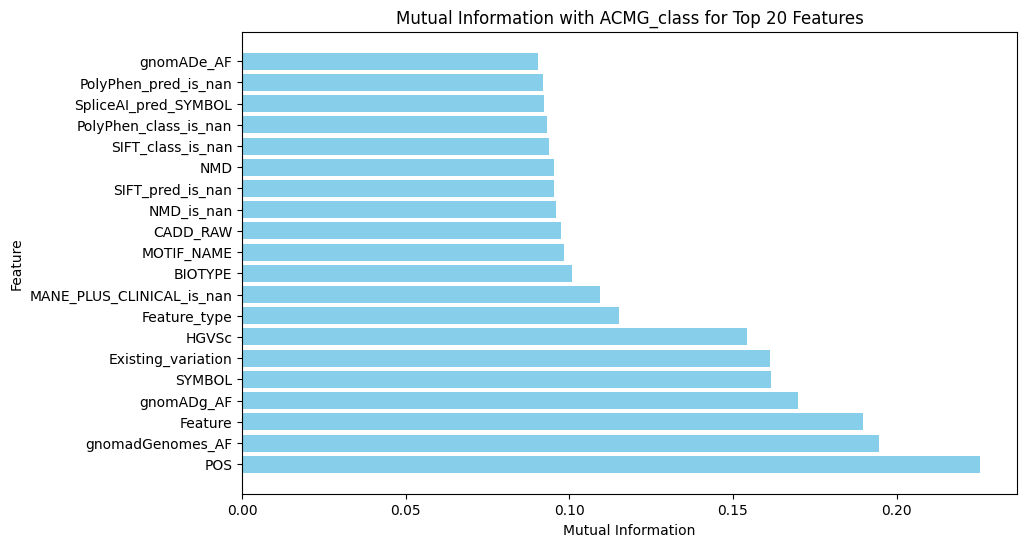

In [76]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df1, target_col)

Datframe 3

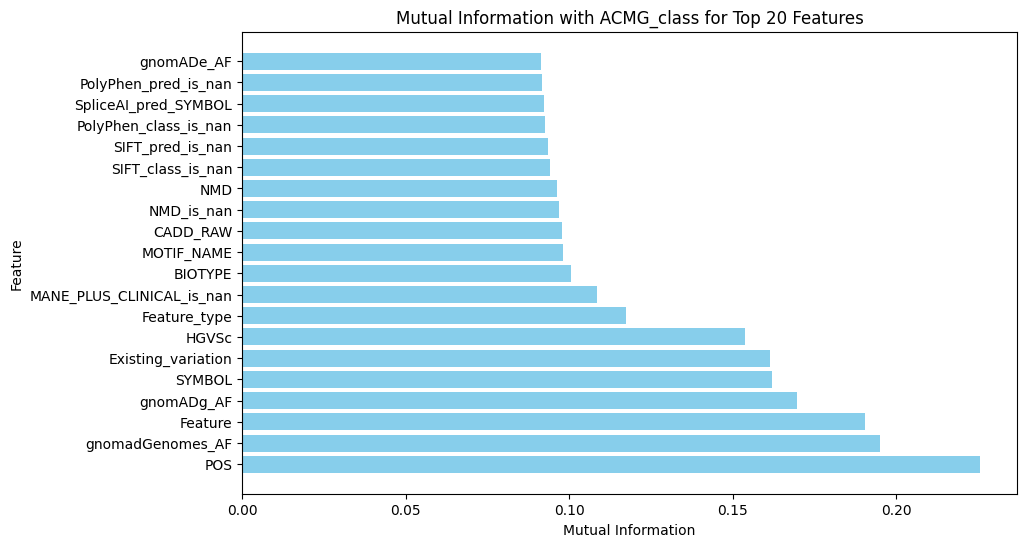

In [77]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df1, target_col)